<a href="https://colab.research.google.com/github/evan-placenis/Transformer_Question_Answering/blob/main/Transformer_Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installations

In [1]:
pip install huggingface_hub


In [2]:
pip install transformers

In [3]:
pip install datasets

## Visualizing Dataset

In [4]:
from datasets import get_dataset_config_names
domains= get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [5]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name = "electronics")
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [6]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [7]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [8]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

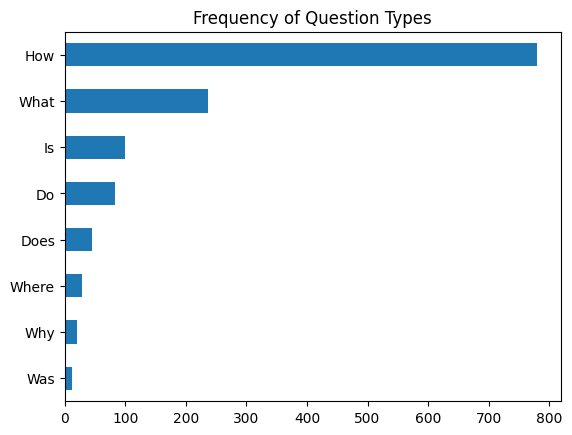

In [9]:
import matplotlib.pyplot as plt
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [10]:
for question_type in ["How", "What", "Is"]:
  for question in (
      dfs["train"][dfs["train"].question.str.startswith(question_type)]
      .sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Tokenizing Text

In [11]:
from transformers import AutoTokenizer
model_cp = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_cp)

In [12]:
#test model
question = "How much music can this hold?"
context = "an MP3 is about 2 MB/minute, so about 12000 hours depending on file size"
inputs = tokenizer(question, context, return_tensors = "pt")

print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 2 mb / minute, so about 12000 hours depending on file size [SEP]


In [13]:
#instantiate QA head
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_cp)

with torch.no_grad():
  outputs = model(**inputs) #** used to pass a dictionary of keyword arguments not a function

print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.8688, -4.7659, -5.3878, -5.1526, -5.2551, -5.4289, -4.9368, -6.1292,
         -0.8688, -0.2995, -0.3499, -1.6610,  3.8678,  5.2934, -0.9047, -4.0212,
         -1.5124, -4.3127, -1.5895,  3.5400,  5.1867, -2.0755, -0.4775, -3.3799,
         -4.9354, -2.4978, -3.2304, -0.8688]]), end_logits=tensor([[-0.9880, -5.4255, -5.0470, -5.0958, -5.4621, -5.4072, -5.1861, -4.5202,
         -0.9880, -3.6473, -0.8124, -3.7084, -3.0676, -0.7624,  0.9611, -2.2644,
          5.3882, -0.5902, -2.8885, -3.5893, -1.5991,  0.3740,  5.4657, -0.1859,
         -4.8145, -2.5421,  0.6297, -0.9880]]), hidden_states=None, attentions=None)


In [14]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx: end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 2 mb / minute, so about 12000 hours


In [15]:

from transformers import pipeline

pipe = pipeline("question-answering", model = model, tokenizer = tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.21835286915302277,
  'start': 16,
  'end': 49,
  'answer': '2 MB/minute, so about 12000 hours'},
 {'score': 0.20207728445529938,
  'start': 16,
  'end': 27,
  'answer': '2 MB/minute'},
 {'score': 0.1962408721446991,
  'start': 38,
  'end': 49,
  'answer': '12000 hours'}]

In [16]:
#set return_overflowing_tokens = True to enable sliding windows for large text passages
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_ex = tokenizer(example["question"], example["context"], return_overflowing_tokens= True,
                         max_length = 100, stride = 25)

for window in tokenized_ex["input_ids"]:
  print(f"{tokenizer.decode(window)}\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]



## Using Haystack to Build a QA pipeline

In [17]:
pip install git+https://github.com/deepset-ai/haystack.git

  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-ajzqrn39
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-ajzqrn39
  Resolved https://github.com/deepset-ai/haystack.git to commit 55b10a3868275243d2fcede14cb00e3b11510930
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [18]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz


In [19]:
# Suppress Haystack logging
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

In [20]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [21]:
# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()

In [22]:
#connect to server
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "8ded366c95e0",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "TXsNOPbGR5msS0jD5aFK8Q",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [23]:
pip install farm-haystack[elasticsearch]

In [24]:

from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [25]:
# flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

In [26]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


**Initializing a Retreiver**

In [27]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [28]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})
print(retrieved_docs[0])

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never ...'>


**Initializing a Reader**

In [29]:
pip install farm-haystack[inference]

In [30]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'query': 'How much music can this hold?', 'no_ans_gap': 12.615935802459717, 'answers': [<Answer {'answer': '2 MB/minute, so about 12000 hours', 'type': 'extractive', 'score': 0.4671657681465149, 'context': 'an MP3 is about 2 MB/minute, so about 12000 hours depending on file size', 'offsets_in_document': [{'start': 16, 'end': 49}], 'offsets_in_context': [{'start': 16, 'end': 49}], 'document_ids': ['969e948be5ee0e1449b84ef0454869a7'], 'meta': {}}>]}


**Putting it together**

In [31]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

In [32]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}},
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





##Domain Adaptation

In [33]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [34]:
product = dfs["train"].query("title == 'B00001P4ZH'")
answers = create_paragraphs(product)

In [35]:
for item in answers:
  qas_list = item['qas']
  for qas_item in qas_list:
    print("Question: ", qas_item["question"])
    print("Answers: ", qas_item["answers"])

Question:  How is the bass?
Answers:  []
Question:  Is this music song have a goo bass?
Answers:  [{'text': 'Bass is weak as expected', 'answer_start': 1302}, {'text': 'Bass is weak as expected, even with EQ adjusted up', 'answer_start': 1302}]
Question:  How is the bass?
Answers:  [{'text': 'The only fault in the sound is the bass', 'answer_start': 650}]
